# Examples

In this notebook we'll show some examples of how you can analyse the YouTube data and use some data from other platforms. These are just some easy suggestions, for people that are not that familiar with Python and they are tailored to get a sense of what is happening in the data.

Interesting information could be:

1. Size of YouTube compared to other platforms.
2. Relative size of YouTube channels.
3. Nature and size of channels.
4. Growth of channels over time, for use in Gapminder.
5. Exploration with regex patterns of some topics discussed in the videos.
6. Exploration with regex patterns of user communities.

## Some considerations

- I used some predefined functions in scenariofunctions.py, to save some time. 
- The comment files (only provided on request) are difficult to parse because of the messy nature of the comments (many characters are used, so it's difficult to find reliable seperators). I therefore decided to use unusual, but rare seperators and quotechars. 
- Please configure the paths to your data in config.py. 
- Everything is coded in Python3

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import relevant libraries.

import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt 
import datetime as dt
import scenariofunctions as sf
import glob 
import csv 
import re
import sys
import os
import config

csv.field_size_limit(sys.maxsize)
%matplotlib inline

In [3]:
# Set paths to data. I've split the data into left, right and Dutch data. You can use the channel files for this.

path_nl = config.PATH_NL
path_right = config.PATH_RIGHT
path_left = config.PATH_LEFT
path_viz = config.PATH_VIZ

## Size of YouTube compared to other social media

Sources: 

1. [Mediamonitor 2018](https://www.cvdm.nl/wp-content/uploads/2018/06/Mediamonitor-2018-Reuters-Institute-Digital-News-Report-Nederland-2018.pdf)
2. [Marketingfacts](https://www.marketingfacts.nl/berichten/jongeren-keren-facebook-massaal-de-rug-toe)
3. [Pew research center](http://www.pewinternet.org/2018/05/31/teens-social-media-technology-2018/)



In [ ]:
# Marketingfacts, percentage that use...

data = {'WhatsApp':[97, 93, 86, 67, 38],
        'Facebook':[72, 89, 77, 69, 58],
        'YouTube':[86, 74, 54, 38, 21],
        'LinkedIn':[12, 45, 36, 14, 7],
        'Instagram':[73, 46, 22, 9, 6],
        'Twitter':[23, 26, 21, 9, 9],
        'Pinterest':[19, 30, 21, 12, 8],
        'Snapchat':[72, 32, 7, 1, 1]       
       }

marketingfacts = pd.DataFrame.from_dict(data, orient='index',
                             columns=['15-19 jaar', '20-39 jaar', '40-64 jaar', '65-79 jaar', '80+'])

In [ ]:
# Pew, percentage of teens that use...

data = {'Youtube': [85, 32],
        'Instagram': [72, 15],
        'Snapchat': [69, 35],
        'Facebook': [51, 10],
        'Twitter': [32, 3],
        'Tumblr': [9, 1],
        'Reddit': [7, 1],
        'Geen van bovenstaande': [3, 3]
       }

pew = pd.DataFrame.from_dict(data, orient='index',
                            columns=['Zegt te gebruiken', 'Zegt het meest te gebruiken'])

## Relative size of channels

Socialblade uses a propriety ranking system, based on view count, subscvriber count and some other metrics that are not public. These data can give you a sense of the relative size of channels. 

Some examples:

Volkskrant ranks:
- Grade: C+
- Subscriber rank: 1,001,161st
- Video view rank: 502,428th
- Socialblade rank: 523,376th
- Estimated Monthly Earnings: €29 - €459
- Estimated Yearly Earnings: €344 - €5.5K

De Correspondent ranks:
- Grade: C
- Subscriber rank: 1,832,426th
- Video view rank: 5,212,726th
- Socialblade rank: 4,469,657th
- Estimated Monthly Earnings: €0.47 - €8
- Estimated Yearly Earnings: €6 - €90

The New York Times ranks:
- Grade: B+
- Subcriber rank: 5,443rd
- Video view rank: 3,210th
- Socialblade rank: 8,201st
- Estimated Monthly Earnings: €5.2K - €82.4K
- Estimated Yearly Earnings: €61.8K - €989.2K


### Different information speres (left, right and Dutch compared)

In [ ]:
spheres = ['right', 'nl_right', 'left']
channel_rankings = pd.DataFrame()

for sphere in spheres:
    if sphere == 'nl_right':
        write_sphere = 'nl_right'
        path = config.PATH_NL
    elif sphere == 'left':
        write_sphere = 'left'
        path = config.PATH_LEFT
    elif sphere == 'right':
        write_sphere = 'right'
        path = config.PATH_RIGHT
    else:
        print('no valid sphere')

    socialblade_input = pd.read_csv(path + 'other_platforms/socialblade_' + sphere + '_summary.csv')
    socialblade = sf.socialblade_ranking(socialblade_input)
    socialblade['sphere'] = write_sphere
    channels_sphere = pd.read_csv(path + 'channels_' + sphere + '.csv', usecols=['channel_id','channel_title'])
    ranking = pd.merge(socialblade, channels_sphere, on='channel_id', how='left')
    channel_rankings = channel_rankings.append(ranking)

#Write to csv
#channel_rankings.to_csv(path_viz + 'socialblade_channel_rankings.csv')

### Growth of these spheres

Socialblade only has data going back to 2015. So it might be interesting to use the video metadata (view count for instance). The problem is that these metrics are not that reliable. A video from 2011 can still gather views. Sociablade gets monthly updates. But let's just try and see what happens, first with the socialblade data and second with the video data.

In [ ]:
spheres = ['right', 'nl_right', 'left']
channel_history = pd.DataFrame()

for sphere in spheres:
    if sphere == 'nl_right':
        write_sphere = 'nl_right'
        path = config.PATH_NL
    elif sphere == 'left':
        write_sphere = 'left'
        path = config.PATH_LEFT
    elif sphere == 'right':
        write_sphere = 'right'
        path = config.PATH_RIGHT
    else:
        print('no valid sphere')

    socialblade_input = pd.read_csv(path + 'other_platforms/socialblade_' + sphere + '_monthly.csv')
    socialblade = sf.socialblade_growth(socialblade_input)
    socialblade['sphere'] = write_sphere
    channels_sphere = pd.read_csv(path + 'channels_' + sphere + '.csv', usecols=['channel_id','channel_title'])
    growth = pd.merge(socialblade, channels_sphere, on='channel_id', how='left')
    channel_history = channel_history.append(growth, sort=False)
    channel_history = channel_history[['channel_title', 'yearmonth', 'subs', 'views', 'sphere']]

In [ ]:
#Write to csv and clear up some memory

channel_history.to_csv(path_viz + 'gapminder_monthly_growth_based_on_socialblade.csv', index=False)
del channel_history

You can find the gapminder file [Here](https://drive.google.com/open?id=16NFYBBD87ZP0o5Mm3z8j0RbucceAxq-i Of course you need gapminder itself, You can download that program [hier](https://www.gapminder.org/tools-offline/).

Some observations: 
1. It looks like somebody emptied a bucket of marbles. 
2. A couple of channels are really large. The Young Turks for instance. 
3. There is certainly a growth of channels, but that could coincide with a general growth of YouTube content. I've got the impression that on the right side, there are more channels of medium size, and more leftist channels that are small. 
4. 2016 and 2017 were important years for the growth of these channels.

We could take a subset to explore further:

- 'Stefan Molyneux', (well known and active since 2008)
- 'Red Ice TV', (popular, white nationalist)
- 'Millennial Woes', (difficult to establish if he's marginal or influential)
- 'Andywarski', (wouldn't call him extreme, but provides a platform (and a format) to host extremists)
- 'Alt-Right Tankie- Eurasianist', (hardcore alt-right)
- 'The Alternative Hypothesis', (ibidem, with many gaming references)
- 'Rebel Media', (professional, growing fast)
- 'Styxhexenhammer666', (more occultist, political commentary)
- 'Jean-Francois Gariépy', (French 'race realist')
- 'Gavin McInnes', (antifeminist, considerable news precense)
- 'Politiekman', (one of the few Dutch youtubers, recently quit)
- 'Black Pigeon Speaks', (popular channel)
- 'Paul Joseph Watson', (affiliated with the Alex Jones empire)
- 'The Thinkery', (philosophical, Sargon of Akkad)
- 'Sargon of Akkad', (big, anti-SJW, gamergate connection)
- 'American Rennaissance', (white supremacy)
- 'Pat Condell', (very popular in the Netherlands, but popularity there has waned)
- 'Vlad Tepesblog', (counter-jihadism, has been active for a long time)
- 'The Iconoclast', (hardcore alt-right)
- 'Dr. Steve Turley', (christian right)
- 'Black Pilled', (hardcore alt-right)
- 'Blonde in the Belly of the Beast', (female youtuber)
- 'Brittany Pettibone', (female, was denied entry to the UK)
- 'T Я U Σ Ð I L T O M', (british, uses fashwave style)
- 'AltRight.com' (Richard Spencer's channel)
- 'The Golden One' (Swedish alt-right, popular in the Netherlands)

In [ ]:
selection = ['Stefan Molyneux',
             'Red Ice TV',
             'Millennial Woes',
             'Andywarski',
             'Alt-Right Tankie- Eurasianist',
             'The Alternative Hypothesis',
             'Rebel Media',
             'Styxhexenhammer666',
             'Jean-Francois Gariépy',
             'Gavin McInnes',
             'Politiekman',
             'Black Pigeon Speaks',
             'Paul Joseph Watson',
             'The Thinkery',
             'Sargon of Akkad',
             'American Rennaissance',
             'Pat Condell',
             'Vlad Tepesblog',
             'The Iconoclast',
             'Dr. Steve Turley',
             'Black Pilled',
             'Blonde in the Belly of the Beast',
             'Brittany Pettibone',
             'T Я U Σ Ð I L T O M',
             'AltRight.com',
             'The Golden One'
]

In [ ]:
videos_right = pd.read_csv(path_right + 'videos_right.csv', encoding='latin-1')
videos_right = sf.add_years_months_to_videos(videos_right)

In [ ]:
vids_we_want = sf.channel_filter(videos_right, set(selection))

In [ ]:
vids_grouped = vids_we_want.groupby(['video_channel_title', 'yearmonth'])[['video_view_count',
                                                                           'video_comment_count',
                                                                           'video_likes_count'
                                                                          
                                                                          ]].agg('sum')

In [ ]:
#Write to csv and clear some memory

vids_grouped.to_csv(path_viz + 'gapminder_monthly_growth_based_on_videos_selection.csv')
del vids_grouped
del vids_we_want
del videos_right

You can find the gapminder file [here](https://drive.google.com/open?id=18FUihglyZPN5v9fgMTB3tBZMUmR-oAfI) vinden.

Some observations:

It's clear that these channels get a large audience from 2013 onwards. Some channels, like Stefan Molyneux, were really marginal before that time, but became suddenly very popular very fast. I think Molyneux deserves his own analysis. 

Let's use the videos now.

In [ ]:
spheres = ['right', 'nl_right', 'left']
channel_history = pd.DataFrame()

for sphere in spheres:
    if sphere == 'nl_right':
        write_sphere = 'nl_right'
        path = config.PATH_NL
    elif sphere == 'left':
        write_sphere = 'left'
        path = config.PATH_LEFT
    elif sphere == 'right':
        write_sphere = 'right'
        path = config.PATH_RIGHT
    else:
        print('no valid sphere')

    videos = pd.read_csv(path + 'videos_' + sphere + '.csv', encoding='latin-1')
    videos = sf.add_years_months_to_videos(videos)
    videos['sphere'] = write_sphere
    channel_history = channel_history.append(videos, sort=False)

vids_grouped = channel_history.groupby(['video_channel_title', 'yearmonth', 'sphere']) \
                                        [['video_view_count',
                                        'video_comment_count',
                                        'video_likes_count'
                                        ]].agg('sum')

In [ ]:
vids_grouped.to_csv(path_viz + 'gapminder_monthly_growth_based_on_videos.csv')
del channel_history
del vids_grouped

In [376]:
growth = pd.read_csv(path_viz + 'gapminder_monthly_growth_based_on_videos.csv')

In [309]:
channels = growth.video_channel_title.unique().tolist()
len(channels)

1765

In [377]:
#chans_per_month = pd.DataFrame()

yearmonths = pd.date_range('2006-01', '2018-11', freq='MS').strftime("%Y-%m").tolist()

for m in yearmonths:
    for_df = {}
    for c in channels:
        for_df.update({c:m})
    df = pd.DataFrame(list(for_df.items()), columns=['channel', 'yearmonth'])
    df.to_csv(path_viz + 'test.csv', mode='a')
    

In [378]:
df = pd.read_csv(path_viz + 'test.csv')

You can find the gapminder file [here.](https://drive.google.com/open?id=1huuxSspihHlcRl3qs4YHuc_POE-Ho0Ie) 

There are a couple of outliers, but the growth of all these channels and the size of the right wing channels is impressive.

## What are the videos about?

Some topics to explore:
1. The manosphere
2. Race and IQ
3. Antisemitism
4. Antimuslim
5. Antirefugees / migration

Let's use the tags. Usually you don't see these tags as a user, but content makers are mindful of how they describe their content (it makes their content easier to find). Later on we can use some bigger guns, like topic modelling.

### Manosphere

First let's get a list of regex patterns with which we can find antifeminist and men rights' activists topics.

In [31]:
query_topic = 'manosphere'

query = ['mgtow', 'metoo', '^rape', 'rape cultur','proud boys', 'incel', 
         'pickup arti', 'rooshv', "men's right", 
         'men rights', 'manospher', 'mascul', 'hypergam', 
         'gynocentr', 'briffault', 'gold digg', 'whores', 
         'vagina', 'parasitic women', 'mens righ',
         'alpha fucks', 'misandry', 'alfa fux'
        ]


In [32]:
videos_right = pd.read_csv(path_right + 'videos_right.csv', encoding='latin-1')
videos_right = sf.add_years_months_to_videos(videos_right)
topic = sf.topic_filter(videos_right, query, query_topic)

found 2941 videos with manosphere


So we have found 2941 videos with these patterns in their tags. What is their total viewcount?

In [ ]:
topic.video_view_count.sum()

More then 220 miljoen. It will probably be less if you remove metoo. We could make the selection of regex patterns a bit more extreme.

In [33]:
query_more_extreme = ['mgtow', '^rape', 'rape cultur','proud boys', 'incel', 
         'pickup arti', 'rooshv', 'manospher', 'hypergam', 
         'gynocentr', 'briffault', 'gold digg', 'whores', 
         'vagina', 'parasitic women',
         'alpha fucks', 'misandry', 'alfa fux'
        ]

In [34]:
topic_more_extreme = sf.topic_filter(videos_right, query_more_extreme, query_topic)

found 1857 videos with manosphere


In [35]:
topic_more_extreme.video_view_count.sum()

113965369.0

114 million views. Let's plot these views over time.

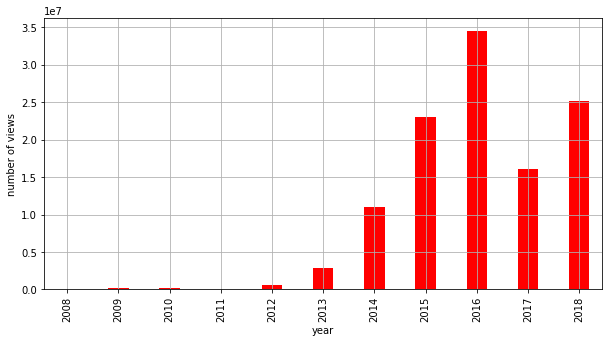

In [36]:
sf.plot_views_per_year(topic_more_extreme)

A peak in 2016, a sharp decline in 2017. What could this mean? 

Let's find the most watched channels then.

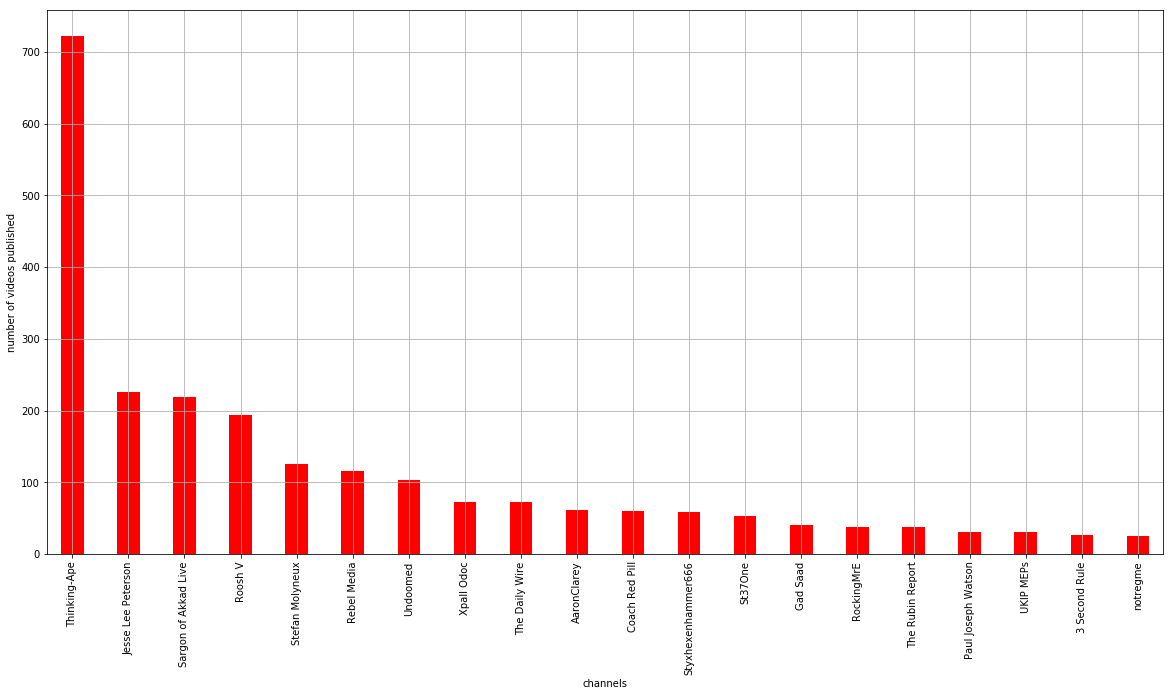

In [37]:
sf.plot_top_channels(topic)

It's clear where you should look if you want to explore this topic in depth: Thinking Ape. 

#### Manosphere - Thinking Ape

In [ ]:
channels_of_interest = ['Thinking-Ape']

manosphere = sf.channel_filter(topic, channels_of_interest)

How often have his videos been viewed?

In [ ]:
manosphere.video_view_count.sum()

Plot these over time.

In [ ]:
sf.plot_views_per_year(manosphere)

Let's have a look at the tags he uses.

In [ ]:
video_tags = sf.extract_tags(manosphere)

In [ ]:
video_tags.tag.value_counts()[0:40]

Some remarks:

1. Stardusk is a [YouTube channel on MGTOW](https://youtube.com/user/Stardusk/videos). This channel appears to be from the same YouTuber as Thinking Ape.
2. Hypergamy is often used in the meaning of 'marrying up' or 'gold digging'. See [Wikipedia](https://en.wikipedia.org/wiki/Hypergamy).
3. Briffault's Law proposes, roughly speaking, that women determine the conditions of a relationship (see [this article](https://www.psychologytoday.com/us/blog/machiavellians-gulling-the-rubes/201610/briffaults-law-women-rule)).
4. Gynocentrism states that everything revolves around women and their interests and needs, see [Wikipedia](https://en.wikipedia.org/wiki/Gynocentrism).
5. Male disposability, also called Male Expandability speaks for itself, see [Wikipedia](https://en.wikipedia.org/wiki/Male_expendability).
6. Women initiate divorce is a term that takes the statistic that 90 percent of divorces are instigated by women. More on this on the [MGTOW forum](https://www.mgtow.com/forums/topic/80-percent-of-divorces-are-initiated-filed-by-women/)

Thinking Ape has over 250 patrons on [patreon.](https://www.patreon.com/user?u=257125)

The tags are generally pretty crude and hostile, although these tags remain hidden for normal users. We could plot these tags over time.

Let's look at some tags, like 'whores'.

In [ ]:
lookup = sf.tag_filter(video_tags, 'whores')

In [ ]:
lookup.head()

Take [this video](https://www.youtube.com/watch?v=8EGN2KfFusM). Invasive species and Human Maladaptation. There isn't much to look at. A map of Australia with the title: 'current extent and anticipated distribution of cane toads in australia'. The video is about the expulsion of native species. What does that have to do with 'whores'? Furtheron, around 16.00 minutes, the video pivots to psychological maladaption and how modern city life is responsible for higher divorce rates. Urban women are simply behaving different than rural women (and not in a very wholesome way of course).

Or [this video](https://www.youtube.com/watch?v=_XaJHKl8kAY): MGTOW Talks: SJWs And the Blue Pill Rebellion in Gaming. It's a conversation lasting about 1 hour and 20 minutes with a regular guest, an Australian and self proclaimed womenizer. It starts with the question if SJWs are professional trolls. 'You can't appease these people'. Then it turns to gamergate and the Sarkeesian crowd. The optics are strange: we see a static anouncement for a software conference. Why is that?

[This](https://www.youtube.com/watch?v=t8eTAsJVnNU) is an interesting example. Difficult to place politically. The 2 hours long conversation seems critical on the alt-right.

This comment, almost sweet, talks about a redpill moment [see](https://www.youtube.com/watch?v=Kx-4s1gGOkA&lc=UgjKEwvAkB7XkXgCoAEC)

#### Coach Red Pill

Often pops up in our lists. 

[This is his introduction video](https://youtu.be/tTOPkyeDsmE?t=40) - with almost 300.000 views. The message is clear. Never trust a woman. Ever. His channel runs ads, I saw an add for Soya products (ALPRO). 

He also vlogs about diversity, immigration and racism. See for instance [this livestream](https://www.youtube.com/watch?v=3Q0K8Zai2xE) with That Guy T, Braving Ruins, Mauritian Struggle, Mouthy Buddha. 


#### Diana Davison

A woman that support the MGTOW frame. See for exampl [thus video](https://www.youtube.com/watch?v=SddZvNQOuFw) (1.5 million views). From the description: 'There is no definitive list of techniques to how women manipulate men but you can see it in action. The case of Dalia Dippolito, caught hiring an assassin to kill her husband, produced really good footage of a woman in full manipulation mode. She was convinced that if she could get her husband physically close to her, she could blind him. And she's right. As long as men remain unaware of their vulnerability to female manipulation they will continue to be victims to it. The phenomenon of MGTOW (Men Going Their Own Way) is a good way to open your eyes. Feminism is bad but it's only a symptom of the bigger problem: gynocentrism and man's vulnerability to female charms. If you want to learn more about this phenomenon you'll find it on youtube: bar bar, JohntheOther, Spetsnaz, Sandman, ThinkingApeTV, RazorBladeKandy2 and others'

#### Turd flying monkey

Top 10 Things Only Red-Pill Men Understand About Women, ruim 600.000 views. 

#### Sandman

Also populair. [This introduction video from 2014](https://www.youtube.com/watch?v=iVXdxaaRiAU) (600.000 views) captures the gist of his work.

#### An Ear for Men

[This man](https://www.youtube.com/watch?v=eTSByNW8H_s) has some issues...

#### Where can we find the manosphereans?

Let's look at the commenters, where are they located? Are these manosphere channels, from user perspective, part of a larger community?

Step 1: extract the video ids and put them in a list.

In [ ]:
manosphere_movies = set(manosphere.video_id)
len(manosphere_movies)

Step 2: run this list through the comment files to find all the commenters.

In [ ]:
fappers = sf.get_comments_by_video_id(manosphere_movies, 'right')

Found alomst 64000 comments on the videos of Thinking Ape.

Stap 3. See where these commenters have been active before and after.

In [ ]:
fappers_to_search = set(fappers.author_channel_id.unique())
len(fappers_to_search)

In [ ]:
faposphere = sf.get_comments_by_author(fappers_to_search, 'right')

We found 1.3 million comments. Where are they?

In [ ]:
fappers_united = pd.merge(faposphere, videos_right[['video_id', 
                                                    'video_channel_title',
                                                    'video_tags',
                                                    'video_view_count',
                                                    'video_comment_count']], on='video_id', how='left')

In [ ]:
sf.plot_top_channels(fappers_united)

Not very suprising. Stefan Molyneux is popular. Millennial Woes suprises me a bit, just like Jean Francois Gariepy. That's pretty far right.

Which users are prolific?

In [ ]:
sf.plot_users(fappers_united)

We see a couple of known users, like Mr.CoolMug who is also active on the Erkenbrand channel.
A couple of them are prominent in the Dutch scene. 

Let's explore the most profilic commenter, Siim Land and look for his 'path' in the alt-right.

In [ ]:
siim = sf.zoom_in_on_commenter(fappers_united, 'Siim Land')

Check if it's really only one person and not two using the same name.

In [ ]:
siim.author_channel_id.nunique()

Yes, only one channel id. Prepare the data for [rawgraph](http://rawgraphs.io). We don't need everything, so let's make a selection.

In [ ]:
siim_grouped = siim.groupby(['year', 'video_channel_title'])['video_channel_title'].agg('count')
siim_grouped

Allright, he has his own channel. That explains the prolificy. Let's try MrCool Mug then.

In [ ]:
mr_cool = sf.zoom_in_on_commenter(fappers_united, 'MrCool Mug')
mr_cool.author_channel_id.nunique()

In [ ]:
mr_cool_grouped = mr_cool.groupby(['year', 'video_channel_title'])['video_channel_title'].agg('count')
mr_cool_grouped

Okay, MrCool Mug is all over the place. Could be an interesting case to explore futher. You can find some data  [here.](https://drive.google.com/open?id=1wCQS-o85-FknSLovHJVjYiovGxH7TVQX) 

### Ras & IQ

In [ ]:
query_topic = 'race'

# Define the search terms that are likely to produce the best results. You can use regular expressions.

query = ['black lives matter', '^blm', 'white lives matter', '^wlm',
         'white genoci', 'replacement', '^race$', 'racist', 'rassis', 
         'racial', '^black$', 'diversity', 'richard spenc',
         '^white$', 'david duke', 'kkk', 'black peop', '^slaver',
         '^greg johns', '^blacks$', 'white ident', 'antiwhite', 'michael brown', 
         'white guilt', 'white privil', 'white suprema', '^realist$',
         '^ethnic', 'affirmative act', 'multiculturali', 'multikul', 'anti white',
        ]

In [ ]:
topic_more_extreme = sf.topic_filter(videos_right, query, query_topic)

### Eugenics

In [4]:
query_topic = 'eugenics'

# Define the search terms that are likely to produce the best results. You can use regular expressions.

query = ['race realis', 'race and iq', 'race iq',
         'charles murray', 'bell curve', 'jared taylor', 
         'eugenics', 'galton', 'genetic', '^dna$',
        'american rennai', 'ancestry', 'amren', '^iq$',
        '^intelligence$']

In [5]:
videos_right = pd.read_csv(path_right + 'videos_right.csv', encoding='latin-1')
videos_right = sf.add_years_months_to_videos(videos_right)
topic = sf.topic_filter(videos_right, query, query_topic)

found 1473 videos with eugenics


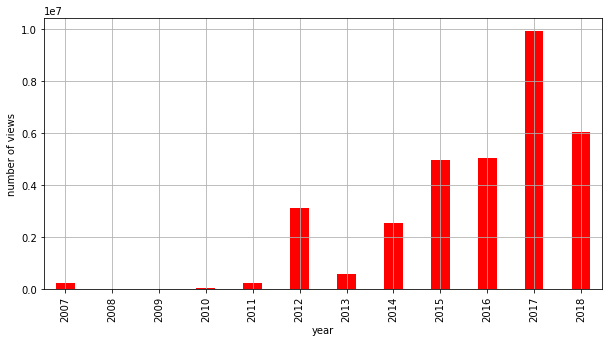

In [6]:
sf.plot_views_per_year(topic)

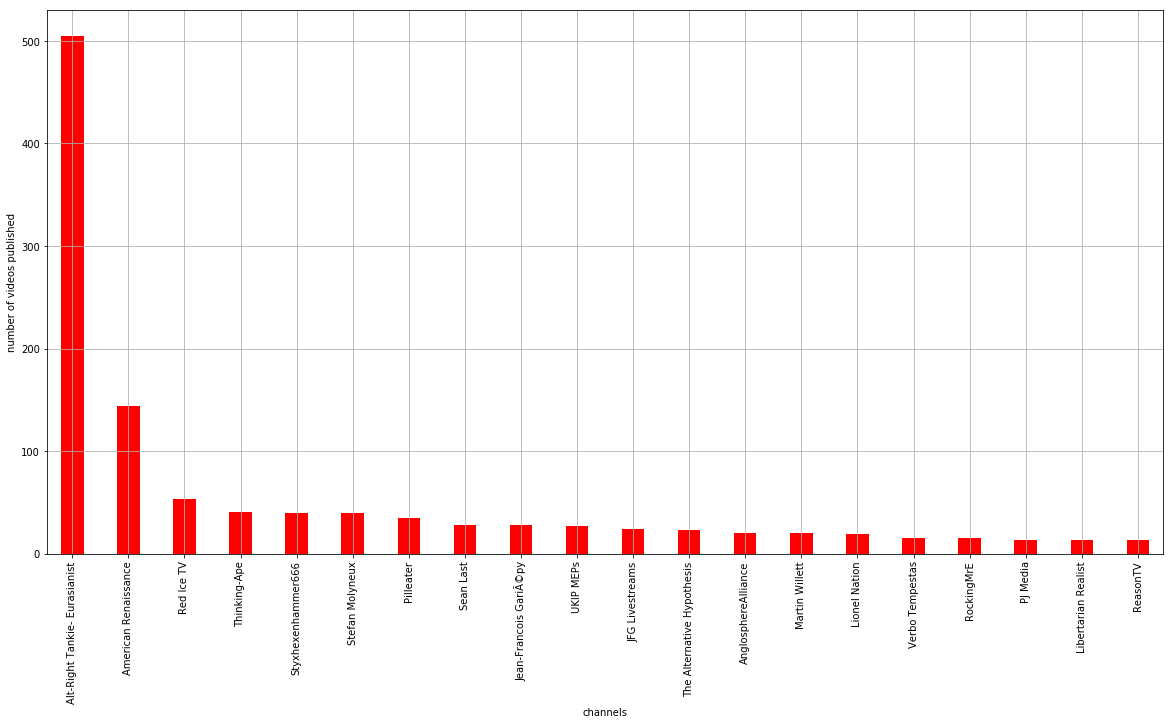

In [7]:
sf.plot_top_channels(topic)

In [13]:
tankie =  topic[topic['video_channel_title'] == 'Red Ice TV']
len(tankie)

53

#### Alt-Right Tankie - Eurasianist

It's not a big channel, but one I encouter a lot, especially in the followers of Erkenbrand. The term 'eurasianist' seems to point at the work of Alexander Dugin, a Russian neofascist. 

[The popular uploads](https://www.youtube.com/channel/UCFWmmu2MmGW8Obc5pNDDJmw/videos?shelf_id=5&sort=p&view=0) get some views in the tens of thousands, but there is not much original content that gets these kinds of views. The more popular content is about Sam Harris, Geert Wilders, Douglas Murray. 
It provides a platform for neonazi (traditionalist worker party) Matt Heimbach.

[This interview for example](https://www.youtube.com/watch?v=rC1_-2bdG8k) - gets a little over 10.000 views, but is pretty hardcore fascism, national bolshewism. The production quality is really low. Topics covered are: -NSM moving towards Strasserism/Yockeyism & Nazbol sympathizing, Stalin, USSR, Jewry vs Great Russian power in USSR, Gulags, Holodomor, Katyn, Dr.'s Plot, Stalin's purges, Soviet support for anti-NATO & anti-Zionist causes, Otto E. Rememer, Stalin's break with Atlantist/ZOG forces. Sinead McCarthy's hatred for Christianity, Russia, Socialism, Dugin, Eurasianism, Orthodox Christian vs Islam & Jewry divide split in Eurasianism, ex-Yugoslavia, Caucasus, Cyprus, the Levant, Greece vs Turkey, Avidgor Eskin, Dogu Perincek

[Nice clip](https://www.youtube.com/watch?v=ne-ORhkM7OQ) to show the low production value. 

#### Dismantle The Matrix

Strange channel, conspiracy meets race and iq. [The Truth About Racial Inequality](https://www.youtube.com/watch?v=moWNOla7dpw&bpctr=1545141520). 

Or [Leftists = Parasitic Subhuman Garbage](https://www.youtube.com/watch?v=A2-tZLEFHp0), 1455 views. Recorded in his car.

### Antisemitisme

Let's restrict the search queries. If you include Soros you get a lot of returns, but those videos don't have to be antisemitic per se.

In [4]:
query_topic = 'antisemitism'

query = ['holohoax', '^jq', 'jewish question',
         '^zog', 'zionis', 'zion wa'
        ]

In [11]:
videos_right = pd.read_csv(path_right + 'videos_right.csv', encoding='latin-1')
videos_right = sf.add_years_months_to_videos(videos_right)
topic = sf.topic_filter(videos_right, query, query_topic)

found 1529 videos with antisemitism


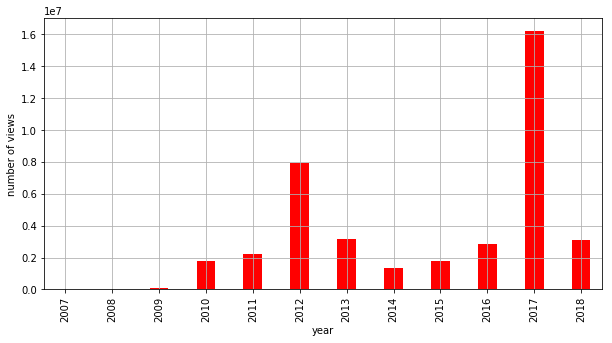

In [13]:
sf.plot_views_per_year(topic)

Strange distribution...

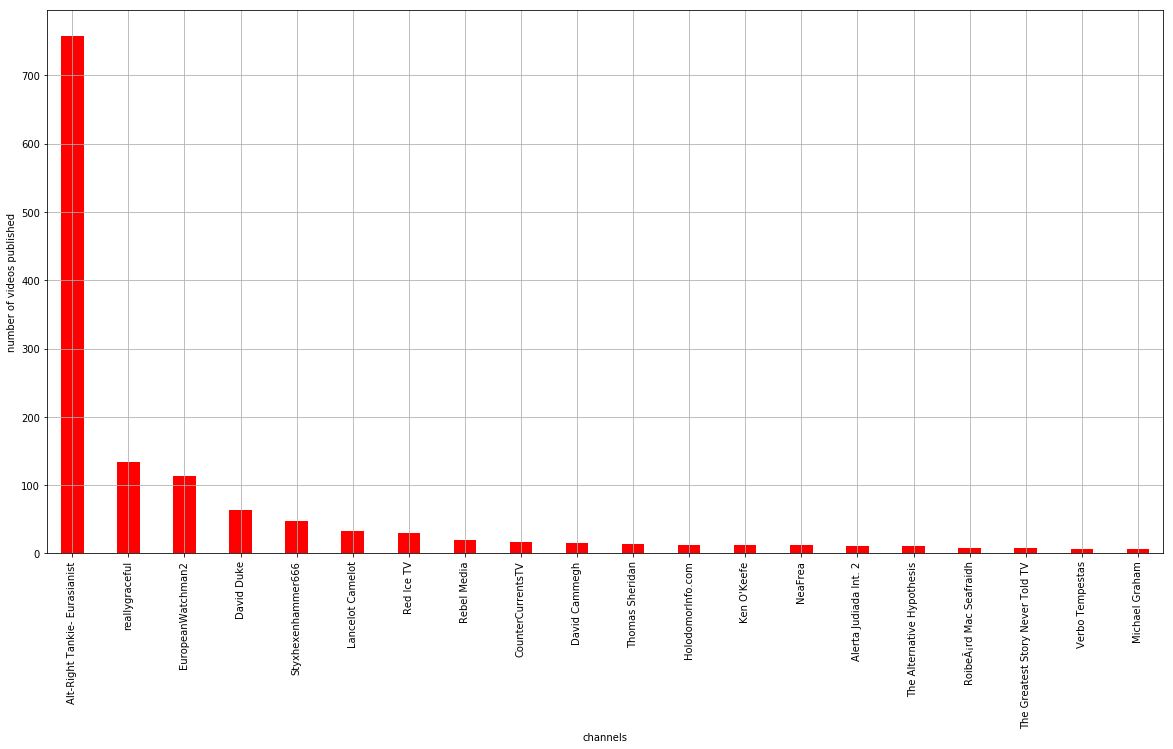

In [14]:
sf.plot_top_channels(topic)

In [15]:
rebel = topic[topic['video_channel_title'] == 'Rebel Media']
len(rebel)

20

Many Rebel Media videos are about antisemitism by leftists. Let's check out Red Ice TV, probably the same.

In [17]:
redice = topic[topic['video_channel_title'] == 'Red Ice TV']
len(redice)

30

In [18]:
redice

video_id           video_published                channel_id  \
37430  KosAUH2JgCI  2018-09-26T01:24:48.000Z  UCFUC7NaTxZanB_FVOJN92eg   
37448  S39ava7v19A  2018-09-03T22:41:44.000Z  UCFUC7NaTxZanB_FVOJN92eg   
37515  QjmwYCu9TRo  2018-05-21T01:11:46.000Z  UCFUC7NaTxZanB_FVOJN92eg   
37599  9VfMVqDs-WA  2018-01-27T08:02:50.000Z  UCFUC7NaTxZanB_FVOJN92eg   
37700  HyRw2vAKxdI  2017-08-03T06:02:37.000Z  UCFUC7NaTxZanB_FVOJN92eg   
37780  fkqTK09i-Xg  2017-05-02T12:22:14.000Z  UCFUC7NaTxZanB_FVOJN92eg   
37916  fpDeXVkZYvM  2016-11-23T09:49:10.000Z  UCFUC7NaTxZanB_FVOJN92eg   
37924  IH9_1Cvk7Cs  2016-11-15T06:41:50.000Z  UCFUC7NaTxZanB_FVOJN92eg   
37979  4xtdfU6PSBY  2016-08-29T06:41:50.000Z  UCFUC7NaTxZanB_FVOJN92eg   
37981  VuzQY1klxzo  2016-08-23T12:58:42.000Z  UCFUC7NaTxZanB_FVOJN92eg   
38037  3toUTUYuZ4M  2016-06-16T01:26:55.000Z  UCFUC7NaTxZanB_FVOJN92eg   
38081  T1TUqw96iVw  2016-03-01T06:12:17.000Z  UCFUC7NaTxZanB_FVOJN92eg   
38119  Xwgb7Kq_Jic  2015-11-20T07:04:21.000Z  UCFUC7NaTxZanB_FVOJN92eg   
38142  4kbJIi0X_SI  2015-10-27T02:46:11.000Z  UCFUC7NaTxZanB_FVOJN92eg   
38207  r8OeQcpAYJA  2015-04-30T06:13:44.000Z  UCFUC7NaTxZanB_FVOJN92eg   
38230  cwgLczzn5gk  2015-03-14T23:18:06.000Z  UCFUC7NaTxZanB_FVOJN92eg   
38231  0oJwOrsh8oA  2015-03-11T17:20:26.000Z  UCFUC7NaTxZanB_FVOJN92eg   
38234  cr56HuPf-9o  2015-03-06T04:12:10.000Z  UCFUC7NaTxZanB_FVOJN92eg   
38240  ghlVsKn6H8I  2015-02-26T11:09:12.000Z  UCFUC7NaTxZanB_FVOJN92eg   
38247  R0NVeLCd4uE  2015-02-16T21:08:44.000Z  UCFUC7NaTxZanB_FVOJN92eg   
38252  pPuYwwt24xc  2015-02-05T22:43:38.000Z  UCFUC7NaTxZanB_FVOJN92eg   
38303  NRK-R9qe7Xc  2014-08-30T05:44:18.000Z  UCFUC7NaTxZanB_FVOJN92eg   
38309  RlGvrnup3fM  2014-08-12T09:44:33.000Z  UCFUC7NaTxZanB_FVOJN92eg   
38311  qmh3XXur_oA  2014-07-29T16:00:02.000Z  UCFUC7NaTxZanB_FVOJN92eg   
38335  y6fPpMUVPoE  2014-06-08T21:39:02.000Z  UCFUC7NaTxZanB_FVOJN92eg   
38343  j5tJAo6T9E8  2014-05-22T13:00:19.000Z  UCFUC7NaTxZanB_FVOJN92eg   
38380  Bt6EyA0IgVI  2014-02-26T12:05:17.000Z  UCFUC7NaTxZanB_FVOJN92eg   
38515  5EfSWz7fnSo  2013-05-07T13:15:19.000Z  UCFUC7NaTxZanB_FVOJN92eg   
38535  2bOCbxqkm0Q  2013-02-23T21:41:25.000Z  UCFUC7NaTxZanB_FVOJN92eg   
38602  I6-wXrhBlbk  2012-07-11T22:23:13.000Z  UCFUC7NaTxZanB_FVOJN92eg   

                                             video_title  \
37430  Third Temple in Jerusalem: Zionists Using Trum...   
37448  Is Israel Just Like Apartheid South Africa? - ...   
37515  The Sickening Opening Ceremony of the US Embas...   
37599  Alfred Schaefer - Thought Criminal Monika Scha...   
37700  Kevin MacDonald - The Importance of Understand...   
37780  New âGeniusâ Show Sells Einstein as The Sm...   
37916  Daniel Hammarberg - Abrahamic Religion: The Da...   
37924  John Lash - Eight Unifying Points for Truth Se...   
37979  Germar Rudolf - Persecution of Revisionists & ...   
37981  Red Ice Live - Michael Hoffman on "Denial," ne...   
38037       Jeff Wilkerson - Sion's Army: The Freemasons   
38081  Christopher Jon Bjerknes - Albert Einstein: Th...   
38119  David Dees - Art Against the New World Order Z...   
38142  Dr. David Duke - Manufactured Crisis in Europe...   
38207  Red Ice Radio - Brandon Martinez - Hour 1 - Th...   
38230  Insight - Hollywoodism: The Ideology that has ...   
38231  Radio 3Fourteen - Monica Stone - The Truth Abo...   
38234  Red Ice Radio -  Jeff Gates - How the Israel L...   
38240  Red Ice Radio - Eric Karlstrom - Hour 1 - New ...   
38247  Red Ice Radio - Tim Murdock - Hr 1 - PSYOP Mem...   
38252  Red Ice Radio - John Lash - Kalika War Party: ...   
38303  Red Ice Radio - Zen Gardner - Hour 1 - Activat...   
38309  Red Ice Radio - David Icke - Origins of Israel...   
38311  Red Ice Radio - Gordon Duff - Veteranâs Toda...   
38335  Red Ice Radio - Israel Shamir - The Ukraine in...   
38343  Radio 3Fourteen - Tim Murdock - The War on Whites   
38380  Red Ice Radio - Christopher Bollyn - Hour 1 - ...   
38515  Red Ice Radio - Kevin Barret

Well... something fishy is going on their. Good that we have checked what is happening.ecked hebben.

Let's try to make a short list of truly antisemitic channels.

In [19]:
to_keep = ['Alt-Right Tankie- Eurasianist',
           'EuropeanWatchman2',
           'David Duke',
           'Red Ice TV',
           'CounterCurrentsTV',
           'David Cammegh',
           'HolodomorInfo.com',
           'NeaFrea',
           "Ken O'Keefe",
           'The Alternative Hypothesis',
           'Alerta Judiada Int. 2',
           'Esoteric Truths',
           'Verbo Tempestas',
           'RoibeÃ¡rd Mac Seafraidh',
           'Electre',
          ]

In [20]:
antisemites = sf.channel_filter(topic, to_keep)

deze selectie levert 1081 videos op.


In [21]:
antisemites.video_channel_title.value_counts()

Alt-Right Tankie- Eurasianist    758
EuropeanWatchman2                113
David Duke                        64
Red Ice TV                        30
CounterCurrentsTV                 17
David Cammegh                     16
HolodomorInfo.com                 13
NeaFrea                           12
Ken O'Keefe                       12
The Alternative Hypothesis        11
Alerta Judiada Int. 2             11
RoibeÃ¡rd Mac Seafraidh            8
Verbo Tempestas                    7
Esoteric Truths                    7
Electre                            2
Name: video_channel_title, dtype: int64

#### Red Ice TV

Let's look at **Red Ice TV**. 

This one is interesting: [Tim Murdock - The War on Whites](https://www.youtube.com/watch?v=j5tJAo6T9E8) (almost 60.000 views). Intervierew is Lana Lokteff, guest is Tim Murdock, the man behind the white rabbit meme. Starts with a tirade, full of conspiracies on how the white race is being muzzled. The tone is very millitant: 'Clean out zionist rats from the government who seeks to destroy us'. 
- Jewish intellectuals
- Obama hates whites
- White children are beaten by gangs of foreigners and everybody looks the other way
- 80 year old white women are reaped with broken bottle
- Sweden, where white women are raped by foreigners and the legal system looks the other way. Why is this not anti-white?
- Who is allowing the lowest of the low to do whatever they whish, while we are muzzled by hate speech laws.
- Freud the hailed jewish psychologist, jewish supremacist
- White are denied jobs, schools and loans
- White race traitors who suffer from pathological disease

First question to Murdock: what are your roots? Europe of course.

Or more conspiracy. [David Icke - Origins of Israel & New Mono World Order](https://www.youtube.com/watch?v=RlGvrnup3fM). David Icke is a prominent English conspiracy theorist. Got 22.000 views. 
Totally insane analysis. The whole order in the middle east was blown up by 'global cabal' on their path to establish a new world order. Anti Jewish imagery says enough.

Then [a video](https://www.youtube.com/watch?v=VuzQY1klxzo) on holocaust denier David Irving (Certain features have been disabled for this video. In response to user reports, we have disabled some features, such as comments, sharing, and suggested videos, because this video contains content that may be inappropriate or offensive to some audiences.) 

**Alt-Right Tankie - Eurasianist**

[Brother Nathanael: Is Elie Wiesel a Fraud?](https://www.youtube.com/watch?v=yZssHFl2Huw&bpctr=1544437912). 
YouTube warns us that we'll probably get an offensive video. We see an orthodox priest who claims that Eli Wiesel commited identity fraud. The tatoo on his arm is supposed to be the wrong number.

[Labor Zionism](https://www.youtube.com/watch?v=BTVq-2QsgoQ&bpctr=1544438307).

**CounterCurrentsTV**

Has 6000 subscribers, which is significant for such an extreme club.
[This video](Greg Johnson & Patrick Le Brun, "Le Pen, Faye, & the Jewish Angle" ) is very telling. 

Finally **European Watchman**

Very marginal. Sommige content zit achter allerlei beperkingen. Je moet je leeftijd invullen. Links onder de filmpjes leiden naar een nogal vage groep (free north west), een lelieblank gezien 'as American as apple pie', met nogal opruiende literatuur.  

This video has been watched over 200.000 times: [Terminally Ill Jewish Whistleblower Aaron Russo Exposes The Zionist World Order.](https://www.youtube.com/watch?v=QyzW8tV-bz4) 
In the comments we find a Dutchman: TheRdamterror. He recommends we watch this video, [Auschwitz: why the gas chambers are a myth.](https://www.youtube.com/watch?v=YwYvawBgNa0&list=PLYaZs66I27LIAmQBClG4XH5W5nGLZnovU&bpctr=1544447491) 

**Holodomor.info** a very interesting channel. Very antisemitic. The Holodomor (killing of millions of Ukrainians by Stalin) is being used to stress that:
- jews should stop whining
- aren't the only victims
- and that leftists use double standards

The channels almost has 2000 subscribers. [This video](https://www.youtube.com/watch?v=c3HdzH9YO1Q) about Trump, who is a Jewish agent, got some 5000 views. 

#### Where can we find the antisemites

In [31]:
antisemites_vids = set(antisemites.video_id.unique())
antisemites = sf.get_comments_by_video_id(antisemites_vids, 'right')

found 37298 comments 
 and 22885 unique commenters


Let's have a look at the Dutch (defined in a list called 'nl')

In [32]:
nl_antisem = antisemites[antisemites['author_display_name'].isin(nl)]

In [38]:
nl_antisem.author_display_name.value_counts()

Daniella Thoelen            5
Gert Tjildsen               3
A-dutch-Z                   3
Joubert x                   3
Linda Bostoen               3
Haasenpad                   3
A Stuijt                    3
Esias Lubbe                 3
georgio jansen              3
Johannes DeMoravia          2
marco mac                   2
TheRdamterror               2
Kevin Zilverberg            2
TheBergbok                  2
Olleke Bolleke              2
Edo Peter                   1
yvonneforsmanatyahoo        1
Peter-john De Jong          1
Wouter Vos                  1
demarcation                 1
H. v. Heeswijk              1
piet ikke                   1
M. van der Scheer           1
Tanya De Beer               1
carolineleiden              1
Cornelis van der Heijden    1
Dennis Durkop               1
Name: author_display_name, dtype: int64

In [ ]:
antisemites_commenters = set(antisemites.author_channel_id.unique())
antisemites = sf.get_comments_by_author(antisemites_commenters, 'right')

In [ ]:
nazis_united = pd.merge(antisemites, videos_right[['video_id', 
                                                    'video_channel_title',
                                                    'video_tags',
                                                    'video_view_count',
                                                    'video_comment_count']], on='video_id', how='left')

In [ ]:
sf.plot_top_channels(nazis_united)

Okay, again the usual suspects

In [ ]:
sf.plot_users(nazis_united)

#### George Soros

Okay, let's look at Soros anyway.

In [45]:
query_topic = 'soros'

query = ['George Soros', '^soros$',
         'open society foundations', '^osf$'
        ]

In [46]:
topic = sf.topic_filter(videos_right, query, query_topic)

found 379 videos with soros


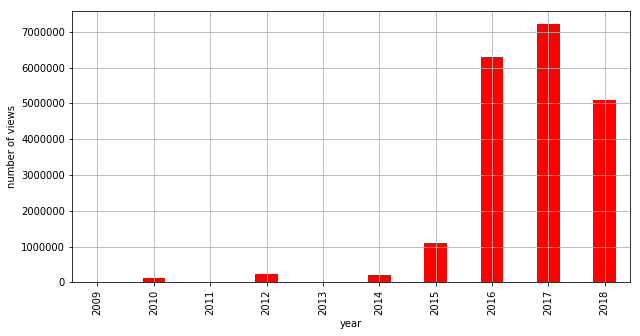

In [47]:
sf.plot_views_per_year(topic)

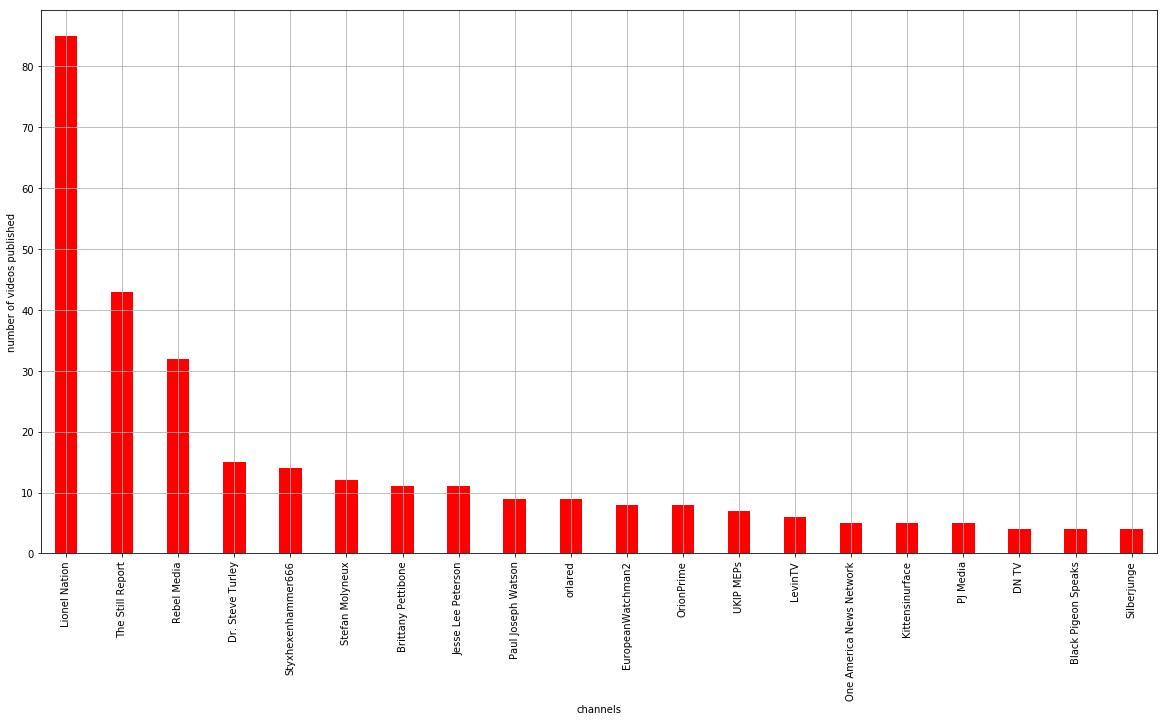

In [48]:
sf.plot_top_channels(topic)

### Anti muslim

In [15]:
query_topic = 'islam'

# Define the search terms that are likely to produce the best results. You can use regular expressions.

query = ['calipha', 'jihad', 'islamis', 'islamic',
         'burqa', 'burka', 'prophet', 'muhamm', 'mohamm', '^islam$',
         'counter-jiha', 'counter jiha', 'contra jiha', 'contra-jiha',
         'kopvod', 'muslim', 'quran', 'koran', 'mosque', 'moskee',
        '^isis$', 'al qaed', 'al-qaed', 'infidel', 'dhimmi', 'sharia', 'robert spence',
        'tommy rob', '^is$', '^isil$', '^imam$', 'moschee', 'dawah', 'salaf']

In [16]:
videos_right = pd.read_csv(path_right + 'videos_right.csv', encoding='latin-1')
videos_right = sf.add_years_months_to_videos(videos_right)
topic = sf.topic_filter(videos_right, query, query_topic)

found 14132 videos with islam


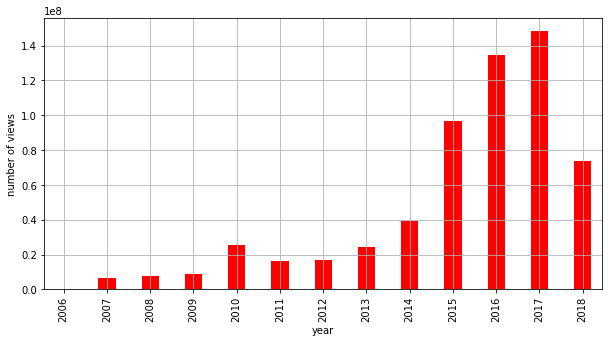

In [17]:
sf.plot_views_per_year(topic)

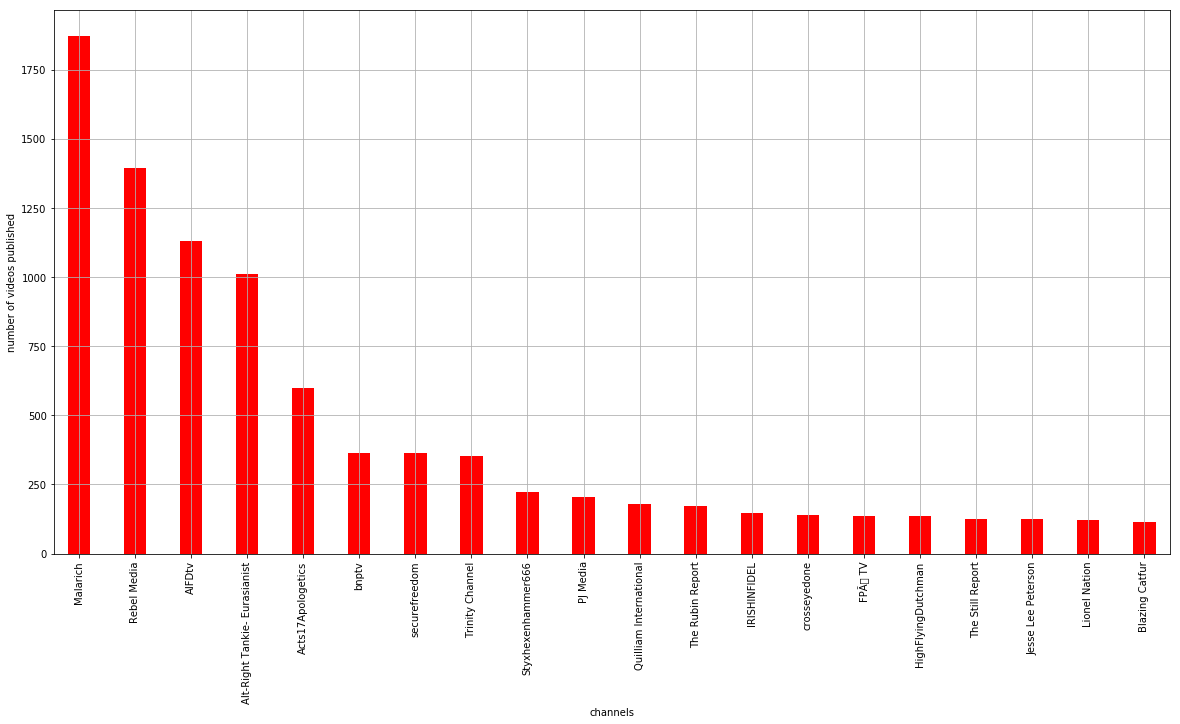

In [18]:
sf.plot_top_channels(topic)

In [19]:
malarich = topic[topic['video_channel_title'] == 'Malarich']
len(malarich)

1872

In [20]:
malarich

video_id           video_published                channel_id  \
31394  JYpUBiNWAHk  2018-10-30T07:19:23.000Z  UCHI172C2wUtZPjuz5u99l-A   
31395  sFWBS7rQFPc  2018-10-28T20:22:02.000Z  UCHI172C2wUtZPjuz5u99l-A   
31396  qWvIJ2pxuug  2018-10-28T20:13:20.000Z  UCHI172C2wUtZPjuz5u99l-A   
31397  iF84vXOAzu4  2018-10-19T08:47:33.000Z  UCHI172C2wUtZPjuz5u99l-A   
31398  GVO6xEJZWh4  2018-10-18T12:14:13.000Z  UCHI172C2wUtZPjuz5u99l-A   
31399  qLowaAhIDUs  2018-10-17T08:19:11.000Z  UCHI172C2wUtZPjuz5u99l-A   
31401  DrdHBGBTOx4  2018-10-15T13:37:59.000Z  UCHI172C2wUtZPjuz5u99l-A   
31408  6f9qYi_XN3g  2018-10-10T04:27:11.000Z  UCHI172C2wUtZPjuz5u99l-A   
31411  fgprEvY_ELg  2018-10-09T15:05:23.000Z  UCHI172C2wUtZPjuz5u99l-A   
31412  8R2d489syJ8  2018-10-09T14:28:21.000Z  UCHI172C2wUtZPjuz5u99l-A   
31414  WIwH4vjOJ7Y  2018-09-17T05:45:38.000Z  UCHI172C2wUtZPjuz5u99l-A   
31415  gEOzow6TOMI  2018-09-16T18:45:51.000Z  UCHI172C2wUtZPjuz5u99l-A   
31417  gBRtkREz69Q  2018-09-11T11:24:25.000Z  UCHI172C2wUtZPjuz5u99l-A   
31424  -alCzb8ddTs  2018-09-04T12:00:17.000Z  UCHI172C2wUtZPjuz5u99l-A   
31425  GZw1Qmw4zec  2018-09-04T09:51:55.000Z  UCHI172C2wUtZPjuz5u99l-A   
31427  Oz4Iopqa6Hc  2018-09-02T13:01:11.000Z  UCHI172C2wUtZPjuz5u99l-A   
31429  4D9i8IZWUms  2018-08-31T19:55:03.000Z  UCHI172C2wUtZPjuz5u99l-A   
31430  xwxbkMiVF-Y  2018-08-30T10:30:54.000Z  UCHI172C2wUtZPjuz5u99l-A   
31431  kcaoY4ym7_4  2018-08-29T07:13:19.000Z  UCHI172C2wUtZPjuz5u99l-A   
31432  wsKKmCTmDmA  2018-08-29T04:57:33.000Z  UCHI172C2wUtZPjuz5u99l-A   
31433  3v96BzAf2eI  2018-08-28T06:20:02.000Z  UCHI172C2wUtZPjuz5u99l-A   
31434  QqYfusYGzVo  2018-08-26T12:44:14.000Z  UCHI172C2wUtZPjuz5u99l-A   
31435  0Z6iR2ahigk  2018-08-25T17:39:40.000Z  UCHI172C2wUtZPjuz5u99l-A   
31437  FLy9mycTaHU  2018-08-20T07:37:45.000Z  UCHI172C2wUtZPjuz5u99l-A   
31438  PBCh86BpFZ4  2018-08-19T11:30:24.000Z  UCHI172C2wUtZPjuz5u99l-A   
31439  a8aKC2Hbb5E  2018-08-17T13:15:41.000Z  UCHI172C2wUtZPjuz5u99l-A   
31440  oFcVVuy6RFs  2018-08-17T11:40:28.000Z  UCHI172C2wUtZPjuz5u99l-A   
31441  tt-S4MQj2-0  2018-08-17T09:40:09.000Z  UCHI172C2wUtZPjuz5u99l-A   
31442  9apnX_znqi8  2018-08-17T08:41:58.000Z  UCHI172C2wUtZPjuz5u99l-A   
31443  OqG3a77aLQQ  2018-08-17T08:12:26.000Z  UCHI172C2wUtZPjuz5u99l-A   
...            ...                       ...                       ...   
33486  G0WNRZVe8aE  2010-09-18T17:15:29.000Z  UCHI172C2wUtZPjuz5u99l-A   
33487  mfwaz_qIPMY  2010-09-16T21:06:07.000Z  UCHI172C2wUtZPjuz5u99l-A   
33488  TOpUwGiIZ_A  2010-09-16T20:53:48.000Z  UCHI172C2wUtZPjuz5u99l-A   
33489  CoVj37oc0s0  2010-09-16T20:42:37.000Z  UCHI172C2wUtZPjuz5u99l-A   
33490  eyLKQVaAWXM  2010-09-16T20:37:17.000Z  UCHI172C2wUtZPjuz5u99l-A   
33492  SZ4auvqf6lM  2010-09-07T21:36:12.000Z  UCHI172C2wUtZPjuz5u99l-A   
33493  nPXoF14vfB8  2010-09-07T20:57:57.000Z  UCHI172C2wUtZPjuz5u99l-A   
33494  xGoV9wB-ZLE  2010-09-07T20:12:37.000Z  UCHI172C2wUtZPjuz5u99l-A   
33495  7ROYf66AL1Y  2010-09-07T19:26:19.000Z  UCHI172C2wUtZPjuz5u99l-A   
33496  Jc6ViZ8e-uE  2010-09-07T18:41:38.000Z  UCHI172C2wUtZPjuz5u99l-A   
33514  Iz02FBo1qfo  2010-06-12T12:36:54.000Z  UCHI172C2wUtZPjuz5u99l-A   
33515  YCRDg2hMBdQ  2010-06-12T10:51:50.000Z  UCHI172C2wUtZPjuz5u99l-A   
33516  Ypf3kGLLim0  2010-06-12T07:52:30.000Z  UCHI172C2wUtZPjuz5u99l-A   
33517  e12L1_cxP_8  2010-06-12T06:22:46.000Z  UCHI172C2wUtZPjuz5u99l-A   
33528  s5z9qYHHXQE  2010-05-02T09:41:04.000Z  UCHI172C2wUtZPjuz5u99l-A   
33545  24hT-zExAxg  2010-03-30T20:32:53.000Z  UCHI172C2wUtZPjuz5u99l-A   
33546  QnohEhC2sAM  2010-03-30T06:06:47.000Z  UCHI172C2wUtZPjuz5u99l-A   
33554  VLZUYrpbKtY  2010-01-26T20:46:46.000Z  UCHI172C2wUtZPjuz5u99l-A   
33555  GO8GsPmoa50  2010-01-24T07:10:28.000Z  UCHI172C2wUtZPjuz5u99l-A   
33565  niBTIE9F0Sw  2009-12-17T08:09:45.000Z  UCHI172C2wUtZPjuz5u99l-A   
33566  QURwEXHrvWo  2009-12-12T09:36:14.000Z  UCHI172C2wUtZPjuz5u99l-A   
33567  bOstId4F5X0  2009-12-11T08:48:24.000Z  UCHI172C2wUtZPjuz5u99l-A   
33568  x3zadHi

### Refugees / Migration

In [22]:
query_topic = 'refugees_immigration'

# Define the search terms that are likely to produce the best results. You can use regular expressions.

query = ['refugees', 'rapefugee', 'vlucht', 
         'asyl', 'asiel', 'asylu', 'gelukszoeke', 'flücht',
         'migrati', 'immigrat', 'migrant', 'immigrant', 'ausl',
         'frontex', 'border', 'azc', 'replacement', 'replace', 
         'kalergi', 'omvolking', 'integrat', 'invasion', 'invasie',
         'demograf', 'demograph'
        ]

In [23]:
videos_right = pd.read_csv(path_right + 'videos_right.csv', encoding='latin-1')
videos_right = sf.add_years_months_to_videos(videos_right)
topic = sf.topic_filter(videos_right, query, query_topic)

found 10966 videos with refugees_immigration


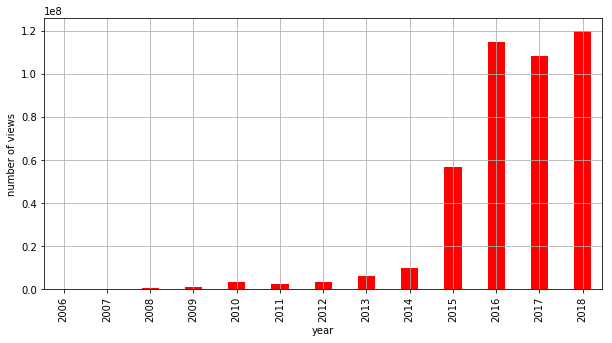

In [24]:
sf.plot_views_per_year(topic)

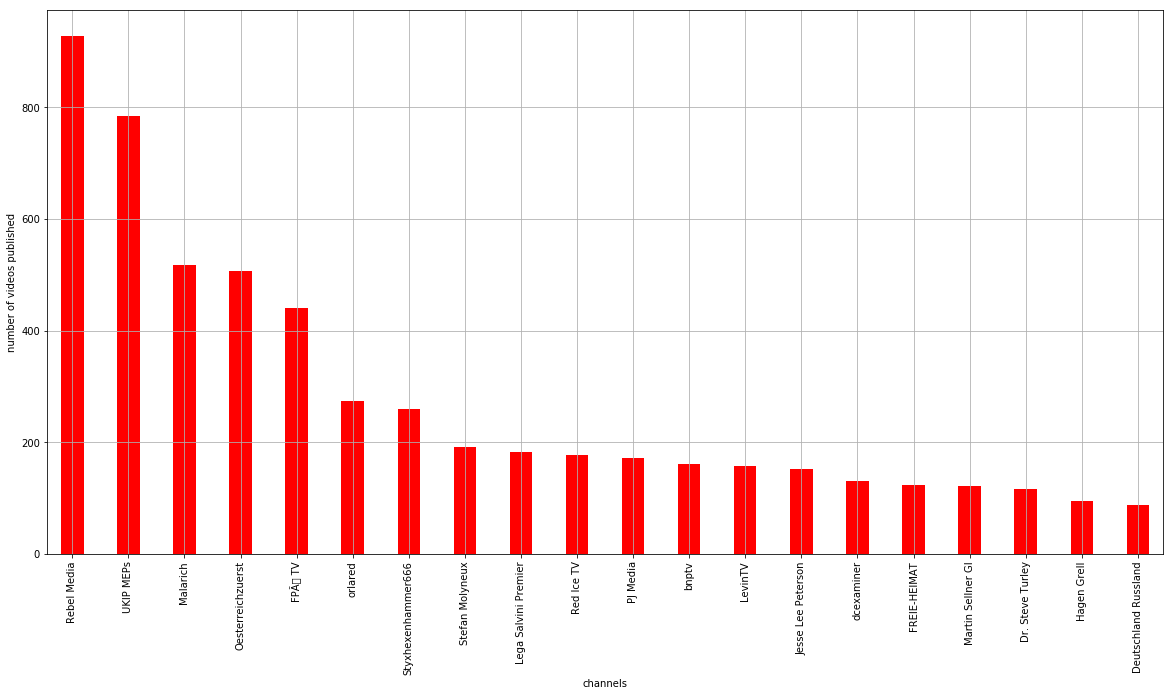

In [25]:
sf.plot_top_channels(topic)

In [27]:
query_topic = 'rapefugee'

# Define the search terms that are likely to produce the best results. You can use regular expressions.

query = ['rapefugee']

In [28]:
videos_right = pd.read_csv(path_right + 'videos_right.csv', encoding='latin-1')
videos_right = sf.add_years_months_to_videos(videos_right)
topic = sf.topic_filter(videos_right, query, query_topic)

found 17 videos with rapefugee


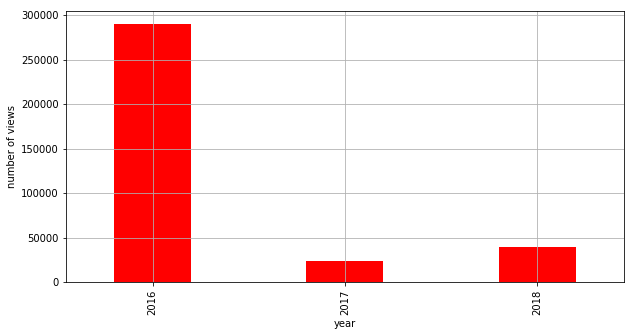

In [29]:
sf.plot_views_per_year(topic)

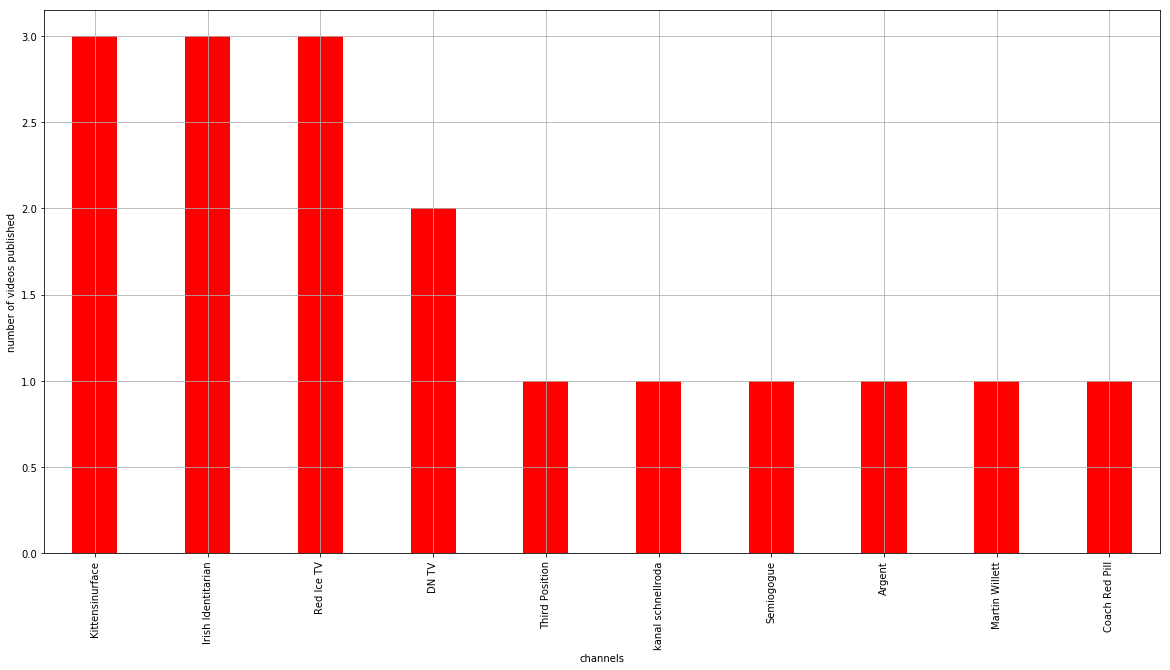

In [30]:
sf.plot_top_channels(topic)

#### PragerU

[Interesting video](https://www.youtube.com/watch?v=stR5nWkq3LU) from Douglas Murray about 'the suicide of Europe'. Professionaly made, 3.5 million views. 

Or [Sweden as the rape capital of Europe.](https://www.youtube.com/watch?v=QCE_vEdA9WU) 

Strong bias in the videos: conservative, nationalist, anti SJW.

### Varia

[Mimir's Head](https://www.youtube.com/watch?v=-QcD9gcPJ1s), the 6 principles of ethnonationalism. 

[Waffen Collider](https://www.youtube.com/watch?v=-UXqNysbNbI&t=4343s&bpctr=1545137905), Who controls the world

[Without white children we will perish](https://www.youtube.com/watch?v=Sojsoco_OsU), from WhiteDate Net.

[WE are the True israelites!?](https://www.youtube.com/user/ThuleanPerspective), from Thulean Perspectives, an Odinist. Strange movie with some funny bits. His channel has over 212 duizend subscribers. An old dude taking a walk.[This](https://www.youtube.com/watch?v=qYK3jPalOcc) comes close to Hitler apologetics.

[traitorsbeware](https://www.youtube.com/watch?time_continue=60&v=A8HhnTOmvpQ) describes her own redpilling moment. This woman clearly has some mental issues. 

## Where are the Dutch commenters 

I've compiled a list with Dutch names extracted from the comments. Where are they active?

In [ ]:
nl_nl = sf.get_comments_by_author_name(nl, 'nl_right')

In [ ]:
nl_right = sf.get_comments_by_author_name(nl, 'right')

In [ ]:
nl_left = sf.get_comments_by_author_name(nl, 'left')

In [ ]:
videos_nl = pd.read_csv(path_nl + 'videos_nl_right.csv', encoding='latin-1')

In [ ]:
nl_nl = pd.merge(nl_nl, videos_nl[['video_id', 
                                'video_channel_title',
                                'video_tags',
                                'video_view_count',
                                'video_comment_count']], on='video_id', how='left')

In [ ]:
videos_left = pd.read_csv(path_left + 'videos_left.csv', encoding='latin-1')
nl_left = pd.merge(nl_left, videos_left[['video_id', 
                                'video_channel_title',
                                'video_tags',
                                'video_view_count',
                                'video_comment_count']], on='video_id', how='left')

In [ ]:
videos_right = pd.read_csv(path_right + 'videos_right.csv', encoding='latin-1')
nl_right = pd.merge(nl_right, videos_right[['video_id', 
                                'video_channel_title',
                                'video_tags',
                                'video_view_count',
                                'video_comment_count']], on='video_id', how='left')

In [ ]:
nl_total = nl_nl.append([nl_left, nl_right], sort=False)

In [ ]:
nl_total.head()

In [ ]:
nl_total.to_csv(path_nl + 'nl_total_comments.csv')

In [ ]:
nl_total = pd.read_csv(path_nl + 'nl_total_comments.csv')

## Violent rethoric in the comments

Can we use regex patterns to find violent rethoric?

In [39]:
query_hate_speech = ['^bitch', '^cunt', 'faggot', '^fag$', '^dyke', '^kike', '^nigger',
                     '^whore', '^cink', 'porch monk', 'wetbacks', 'nigga', 'piece of shit', 
                     '^coon','^spic$', 'jew bastar', 'savages', 'fuck them', 'fuck you',
                     '^slut$', 'kangz', 'dindu nuf', '^goyim', '^shekels',
                     'globalist', 'fuck her', 'feminazi',
                    
                    ]

query_hate_speech_nl = ['kanker', '^hoer', '^slet$', 'nikker', 'vuile jood', 
                        'vuile moslim', 'tyfus', '^neger$', 'zwarte aap', 
                        '^tering', 'vieze jood', '^kut', 'val dood', 'ga dood',
                        'dat je doodgaat', 'kk marokkaan', 'kk mocro' , 'parasieten', 'ratten$',
                       '^tuig', 'afknallen', 'vieze jood', 'vieze jodi', 'beurt nodig',
                        'ik zou haar doen', 'zou je haar doen', 'grafhoer',
                        'globalist', 'klootzak', 'haatbaard', '^hakbar',
                        'dobberneger', 'stoephoer', 
                       
                       ]

query_violence_nl = ['ze doodmaken', 'in opstand komen', 'tijd voor actie', 'genoeg is genoeg', 
                    'ze verdelgen', 'ze vernietigen', 'geen gelul meer', 'ik je verkrachten', 'je neuken',
                     'ze vergassen', 'leg ze aan het gas', 'trein naar het oosten',
                     'maak ze dood', 'dit is oorlog', 'tijd voor oorlog', 'praten is voorbij'
                     
                    ]
    
        
query_violence = ['we should kill', 'i want to rape', 'this is war', 'enough is enough',
                  'talking is over', 'time for action', 'stand up and fight','should be raped',
                  'should be killed', 'should kill','should punch', 'should murder', 'i will kill',
                    'i will hurt', 'kill them all','kill those savages', "i'm going to shoot",
                  "i'm going to kill", "i'm going to rape", 'need to punish', 'i will punish',
                  'kill yourself', 'be hanged', 'time to fight', "let's fight", 'hope you get killed',
                  'hope you get raped', 'lynch them', 'exterminate', 'destroy them', 'deport them',
                  'rape them', 'shoot them', 'punish them', 'hang them', "i'll kill"
                 ]


In [40]:
hate_speech = query_hate_speech + query_hate_speech_nl
violent_speech = query_violence + query_violence_nl

In [ ]:
violence_right = sf.get_comments_by_topic(violent_speech, 'right')

In [41]:
violence_left = sf.get_comments_by_topic(violent_speech, 'left')

found 130872 comments 
 and 87245 unique commenters


In [42]:
violence_left.to_csv(path_viz + 'violence_left.csv')

In [43]:
violence_nl_right = sf.get_comments_by_topic(violent_speech, 'nl_right')

sphere not found 
please try again
found 616 comments 
 and 545 unique commenters


In [44]:
violence_nl_right.to_csv(path_viz + 'violence_nl_right.csv')

[autoreload of six failed: Traceback (most recent call last):
  File "/home/dim/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/home/dim/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 392, in superreload
    update_generic(old_obj, new_obj)
  File "/home/dim/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 329, in update_generic
    update(a, b)
  File "/home/dim/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 274, in update_class
    old_obj = getattr(old, key)
  File "/home/dim/.local/lib/python3.6/site-packages/six.py", line 93, in __get__
    setattr(obj, self.name, result)  # Invokes __set__.
AttributeError: 'NoneType' object has no attribute 'cStringIO'
]


In [ ]:
violence.to_csv(path_viz + 'violence_right.csv')

In [4]:
violence_right = pd.read_csv(path_viz + 'violence_right.csv')

In [6]:
violence_left = pd.read_csv(path_viz + 'violence_left.csv')

In [7]:
violence_nl = pd.read_csv(path_viz + 'violence_nl_right.csv')

In [13]:
violence = violence_right.append([violence_left, violence_nl], sort=False)

In [15]:
violence = violence.drop_duplicates()

In [16]:
len(violence)

210506